# Lab 3 - Asking a Statistical Question

##### PHYS434 - Advanced Laboratory: Computational Data Analysis
##### Professor: Miguel Morales
<br>

##### Due date: 10/23/2021
##### By Erik Solhaug
<br>

This week we are going to concentrate on asking a statistical question. This process almost always consists of 3+ steps:
 1. Writing down in words very precisely what question you are trying to ask.
 2. Translating the precise english question into a mathematical expression. This often includes determining the pdf of the background (possibly including trials), and the to integral to do to obtain a probability. 
 3. Coverting the probability into equivalent sigma
 
 

In [2]:
# Importing needed libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats, signal

# This sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (15,10)
# This sets the fontsize of the x- and y-labels
fsize = 30
lsize = 24

## Problem 1

In our first example we are looking at the temperature reading (meta-data) associated with an experiment. For the experiment to work reliably, the temperature should be at around 12 Kelvin, and if we look at the data it is mostly consistent with 12 Kelvin to within the 0.4 degree precision of the thermometry and the thermal control system (standard deviation). However, there are times when the thermal control system misbehaved and the temperature was not near 12 K, and in addition there are various glitches in the thermometry that give anomalously high and low readings (the reading does not match the real temperature). We definitely want to identify and throw out all the data when the thermal control system was not working (and the temperature was truly off from nominal). While it is possible to have an error in the thermometry such that the true temperature was fine, and we just had a wonky reading, in an abundance of caution we want to throw those values out too.

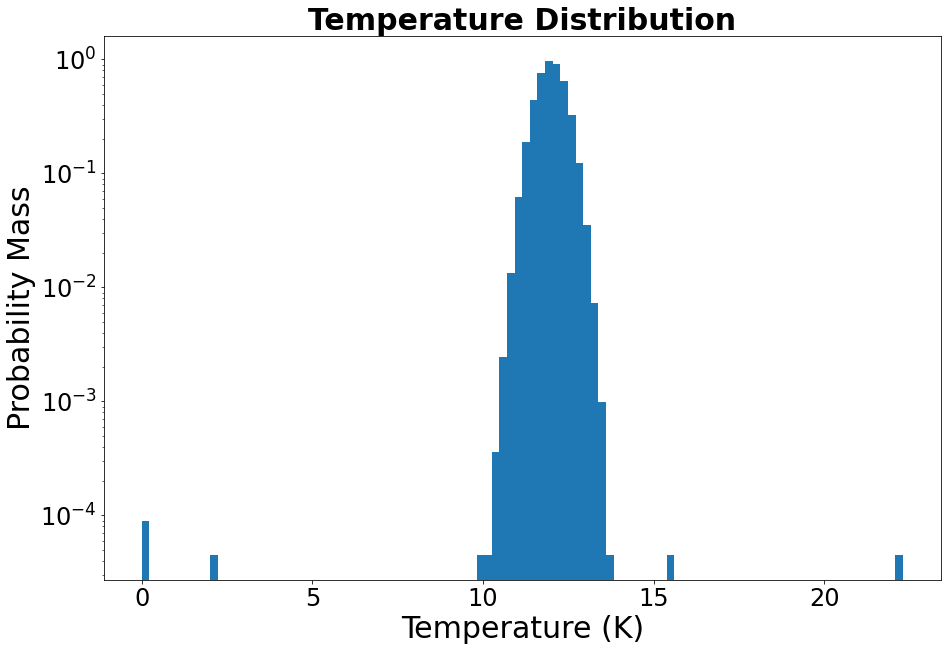

In [3]:
d = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
plt.tick_params(labelsize = 24)
plt.yscale('log')
ax.set_xlabel('Temperature (K)', fontsize = fsize)
ax.set_ylabel('Probability Mass', fontsize = fsize)
ax.set_title('Temperature Distribution', fontsize = fsize, fontweight = 'bold')
plt.show()

## A)

### 1.

Let's play around with the data and come up with criteria for throwing out certain data points.

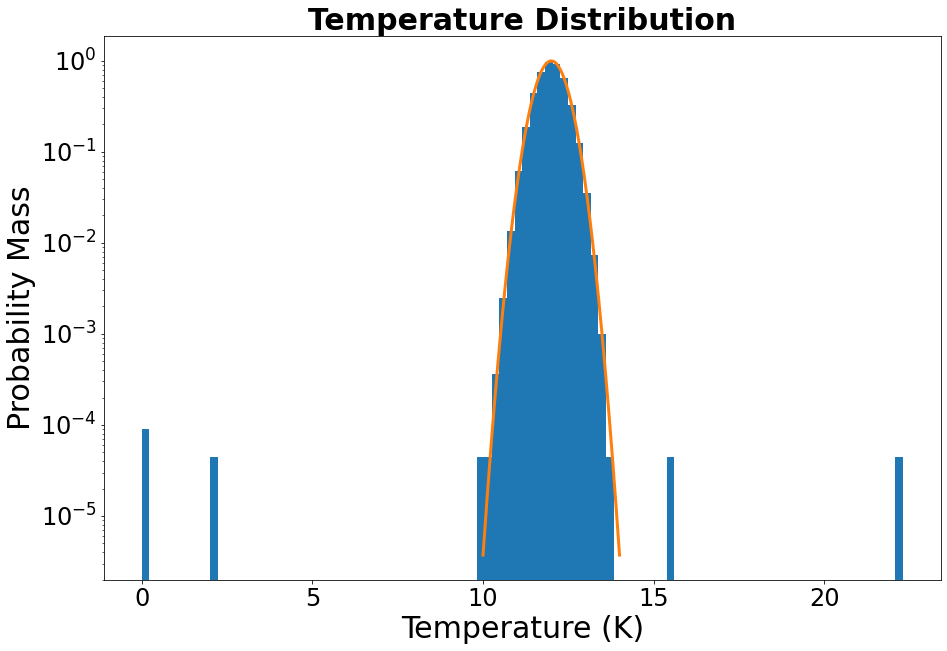

In [4]:
x = np.linspace(10, 14, 1000)
d2 = stats.norm.pdf(x, loc = 12., scale = 0.4)
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
ax.plot(x, d2, linewidth = 3)
plt.tick_params(labelsize = 24)
plt.yscale('log')
ax.set_xlabel('Temperature (K)', fontsize = fsize)
ax.set_ylabel('Probability Mass', fontsize = fsize)
ax.set_title('Temperature Distribution', fontsize = fsize, fontweight = 'bold')
plt.show()

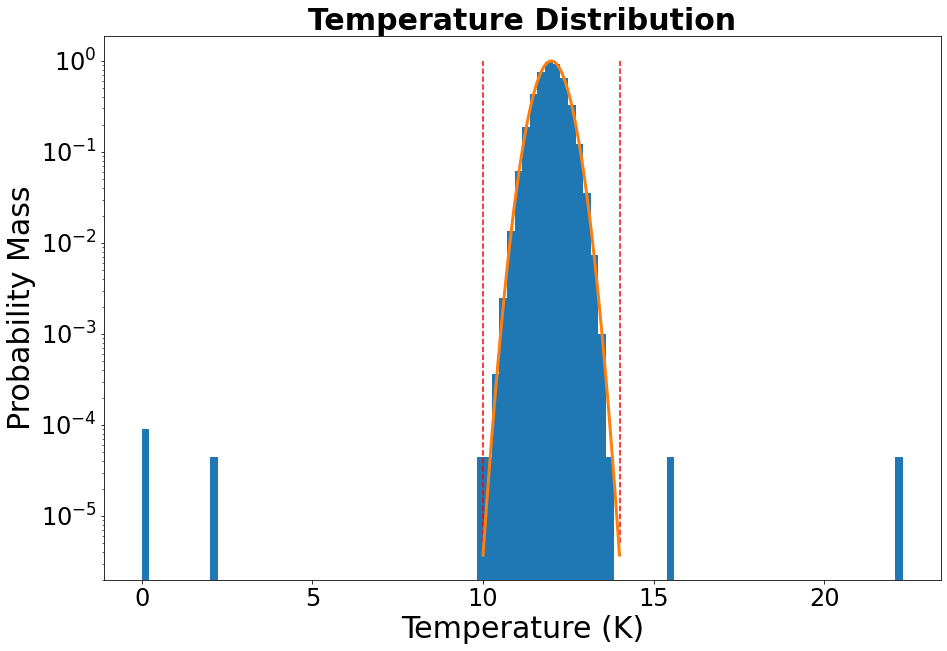

In [5]:
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
ax.plot(x, d2, linewidth = 3)
ax.vlines(10, 5e-6, 1e0, color='r', linestyle = '--')
ax.vlines(14, 5e-6, 1e0, color='r', linestyle = '--')
plt.tick_params(labelsize = 24)
plt.yscale('log')
ax.set_xlabel('Temperature (K)', fontsize = fsize)
ax.set_ylabel('Probability Mass', fontsize = fsize)
ax.set_title('Temperature Distribution', fontsize = fsize, fontweight = 'bold')
plt.show()

Let's suggest boundaries of values 10 and 14 (+-2 on each side of the mean) to discriminate 'bad' data points - essentially, setting these as thresholds for the data to be in between. 

### 2.

If we take the survival function of 14 under our pdf we get the following probability and sigma:

In [6]:
norm_dist = stats.norm(loc = 12., scale = 0.4)
prob = norm_dist.sf(14)
sigma = round(-stats.norm.ppf(prob, loc=0, scale=1), 4)
sigma

5.0

This seems to be a good threshold for our data - so that if the data value lies beyond five sigma from the mean of the distribution, then we will throw the data point away. 5 sigma seems to be placed right outside the majority of our distribution and excludes the data point that are outliers.

Then, our statistical question becomes:

_Is the probability of getting the data point in our distribution smaller than $5\sigma$?_

If this is the case, we will throw out the data point.

### 3.

We now restate our question in mathematical terms. For a data point with value $V$.

In [7]:
def exclude_data(dist, V, sigma):
    '''
    Returns True if data point should be thrown out,
            False if it should be kept.
    '''
    Vprob = dist.sf(V)
    Vsigma = -stats.norm.ppf(Vprob, loc=0, scale=1)
    if abs(Vsigma) > sigma:
        exclude = True
    else:
        exclude = False
    return exclude

We run this in a loop and get:

In [8]:
included_array = []
excluded_array = []
for item in d:
    if exclude_data(norm_dist, item, sigma):
        excluded_array.append(item)
    else:
        included_array.append(item)
print(f'Excluded: {excluded_array}\n\n'
      f'Included: {included_array}')

Excluded: [2.1, 0.0, 0.0, 15.6, 22.3]

Included: [12.513734621520028, 12.583696597846519, 12.153761433051745, 12.44462203581894, 12.196592184022466, 12.547585359441966, 12.180224318681692, 12.205736534086903, 12.182958122843615, 10.707814410853903, 12.512475827188458, 11.673421283210741, 11.91108536116488, 11.957428049880514, 12.009081283116398, 12.290804195506631, 11.412312580473003, 11.867628389495755, 12.22110003973066, 11.305268251809183, 11.845832215885055, 11.331682288462314, 11.938670716233704, 12.832058645723734, 12.348683845984972, 12.80802891707733, 12.39261838250249, 11.95039691777428, 12.11091251177737, 12.286960269224714, 11.706871096340581, 12.591861875490082, 12.081141181406068, 12.18380802107086, 12.306496038047031, 11.87888163584203, 12.655867677043664, 11.852960091607471, 11.472799138805023, 11.307365474046984, 11.352048299211168, 11.686164271612968, 12.23628757566612, 11.945372705360425, 12.191126000675773, 12.135086970350509, 12.286092799948577, 12.32389660356167, 1

### 4.

Reminder: Our 'bad' data points are {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}

In [9]:
bad_data = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]
kept_bad_data = []
for i in included_array:
    for k in bad_data:
        if i == k:
            kept_bad_data.append(i)
bad_data, kept_bad_data

([10.0, 10.3, 2.1, 0.0, 0.0, 15.6, 22.3, 12.7], [10.0, 10.3, 12.7])

In [10]:
len(d) - len(bad_data), len(bad_data)

(100000, 8)

In [11]:
len(included_array), len(excluded_array), len(excluded_array) + len(included_array), len(kept_bad_data)

(100003, 5, 100008, 3)

We construct a truth table showing our results from above:

|  | **True T** | **Bad T** |
| --- | --- | --- |
| Test Include | 100000 | 3 |
| Test Exclude | 0 | 5 |
| Total | 100000 | 8 |

## B)

Now, we evaluate how the omissions (throwing out 'good' data) depends on the threshold (sigma) I chose above.

Since the test does not omit any good data for my threshold of $ 5\sigma $, it does not depend on the threshold if the threshold increases (to a larger sigma). However, if we decreased the threshold so that the sigma would converge onto the actual good data points - so that the width of the statistical "inclusion" is narrower than the distribution of the normal distribution in the background - and then the test would start excluding good data points.

## C)

There are still some data points that are 'bad' data that gets into my final distribution even after the statistical test. These are located among the distribution of the background, and so they are included as my test does not omit them since they are within the 'inclusion zone' defined by my threshold of $ \pm \: 5\sigma $.

There is no way I can change my threshold - effectively the width of the inclusion zone - so that the test would not also exclude _good_a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax) data.

## Problem 2

In this example we will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two-dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS. Or said another way, if I histogram how far all the (stationary) stars appear to have moved I get something like:

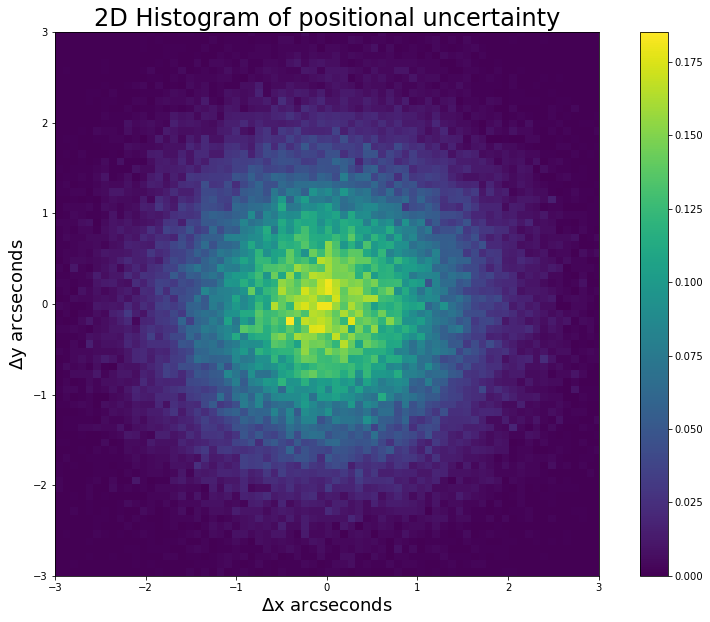

In [12]:
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax);

If I have a potential asteroid, it will have some true movement between the images. We would like a '5 sigma' detection of movement. What is that distance in arcseconds?

1. What is the question in words?
2. What is the question in math? [Hint: Come up with an analytic description of your pdf(). The Blue Book may be helpful here.]
3. What distance in arcseconds represents a 5 sigma detection of motion?


## 1.

We know that our 2D Gaussian is related to a Rayleigh distribution, such that our Rayleigh distribution will have a standard deviation of $ \sqrt{\sigma} $ if the Gaussians have a standard deviation of $ \sigma $. 

Let's state our statistical question:

What is the distance in arcseconds that when integrated from the right up to that value (distance) corresponds to a probability of 5 'sigma'?

## 2.

For a value V, Rayleigh distribution of $ R(x) $ and standard normal distribution of $ N(x) $:

$$ \int_{V}^{\infty}{ R(x) dx} = \int_{\sigma}^{\infty}{ N(x) dx} $$

Then, we take the $cdf()$ of the latter integral (which gave us a probability) to find the 'sigma'.

## 3.

In [24]:
prob_5sigma = 1/3.5e6
sigma_gaussian = 1
sigma_rayleigh = np.sqrt(sigma_gaussian)
rayleigh = stats.rayleigh(scale = sigma_rayleigh)
rayleigh.ppf(1 - prob_5sigma)
# stats.norm.isf(rayleigh.sf(prob_5sigma))

5.489676406965609

Let's just first plot what our distribution looks like before we start doing summations. For our Poisson distribution, we pick the value $\mu = 5.2$ to be the number of expected incoming cosmic-rays in one day. Since we are observing over only one day, we set $N = 1$.

In [14]:
mu = 5.2

In [15]:
def plot_sum(distribution, bins, left, right, fsize, lsize):

    fig, ax = plt.subplots(1, 1)
    plt.tick_params(labelsize = lsize/2)
    ax.stairs(poisson, bins, fill=True)
    ax.set_xlim([left, right])
    ax.set_xlabel('N gamma-rays', fontsize = fsize)
    ax.set_ylabel('Probability Mass', fontsize = fsize)
    ax.set_title('Summed Probability Distribution', fontsize = fsize, fontweight = 'bold')
    plt.show()

In [4]:
def Nconvolve(dist, N):
    dist_two = dist
    if N != 1:
        for i in range(0, N-1):
            dist_two = signal.convolve(dist, dist_two)
    dist = dist_two
    return dist

In [5]:
N = 1

xlim1, xlim2 = (0, 20)
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
poisson = stats.poisson.pmf(x, mu)

Nconvolve(poisson, N)

bins = np.arange(xlim1, len(poisson)+1)
bins = bins - (bins[1]-bins[0])/2

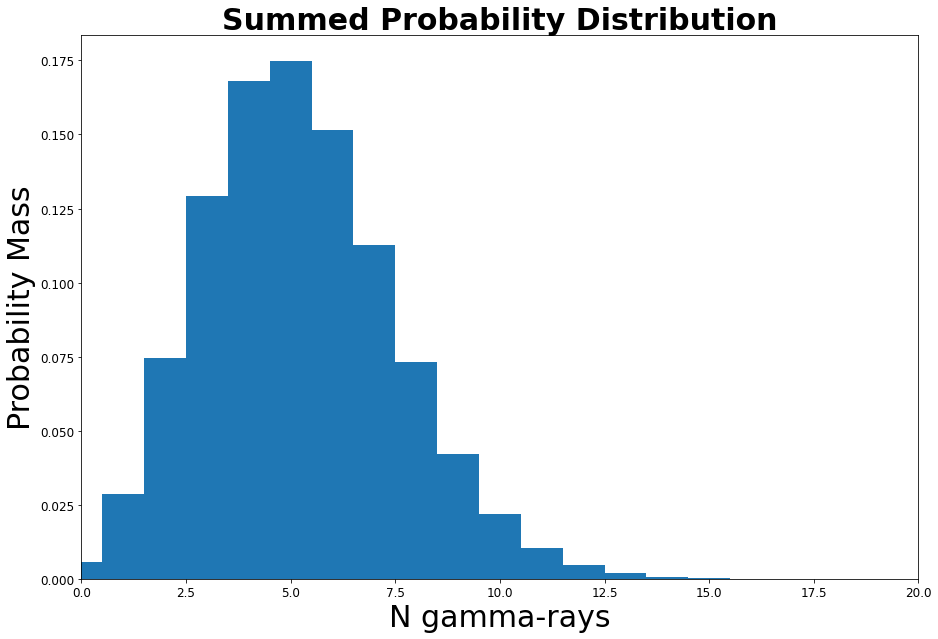

In [6]:
plot_sum(poisson, bins, 0, 20, fsize, lsize)

We sum the above distribution with itself several times by varying N. N corresponds to how many identical Poisson distributions are summed together. 

In [7]:
N = 2

xlim1, xlim2 = (0, 20)
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
poisson = stats.poisson.pmf(x, mu)

poisson = Nconvolve(poisson, N)

bins = np.arange(xlim1, len(poisson)+1)
bins = bins - (bins[1]-bins[0])/2

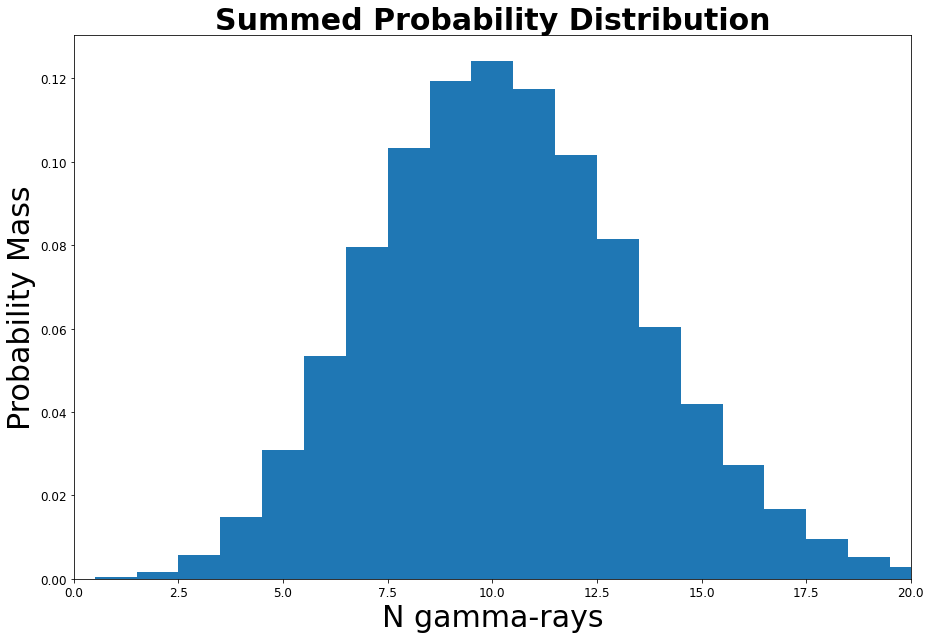

In [8]:
plot_sum(poisson, bins, 0, 20, fsize, lsize)

We see that as we sum the two identical distributions together, their shape remains the same. However, their standard deviations are smaller now that the sum yields a summed probability distribution that is taller than before.

We continue showing this by summing 10 days of the background together.

In [9]:
N = 10

xlim1, xlim2 = (0, 20)
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
poisson = stats.poisson.pmf(x, mu)

poisson = Nconvolve(poisson, N)

bins = np.arange(xlim1, len(poisson)+1)
bins = bins - (bins[1]-bins[0])/2

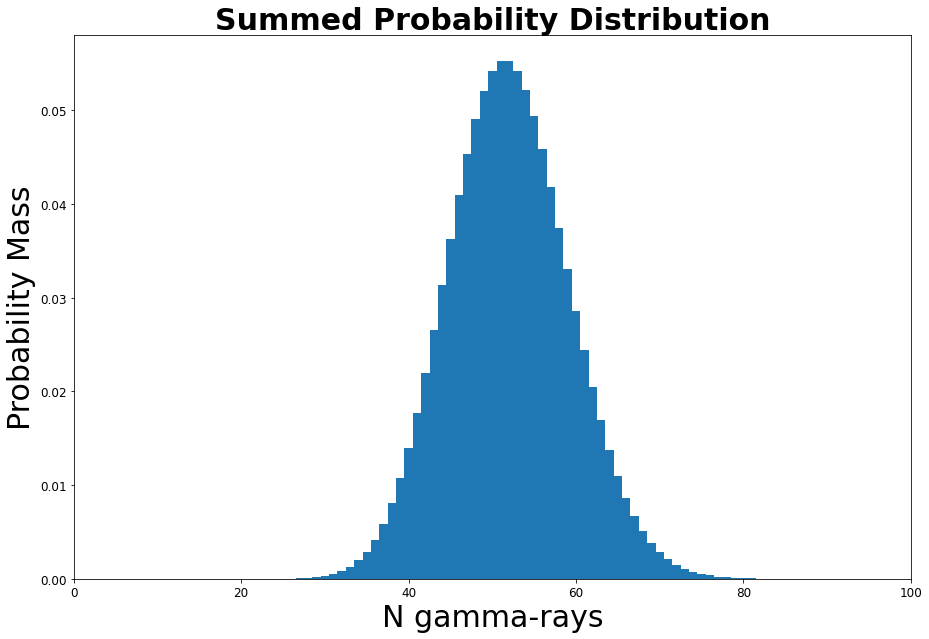

In [10]:
plot_sum(poisson, bins, 0, 100, fsize, lsize)

We see that as we sum the background with itself over and over, the summed distribution starts looking more and more like a Gaussian distribution and more symmetric around its mean.

We also see that as we sum several distributions together, the mean is shifted, as we would expect now that we may observe more gamma rays when we increase our span of observations.

## B)

For example, after 5 days the distribution represents the sum of 5 identical Poisson distributions. And this, as we show below, is still a Poisson distribution. 

In [11]:
N = 5

xlim1, xlim2 = (0, 20)
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
poisson = stats.poisson.pmf(x, mu)

poisson = Nconvolve(poisson, N)

bins = np.arange(xlim1, len(poisson)+1)
bins = bins - (bins[1]-bins[0])/2

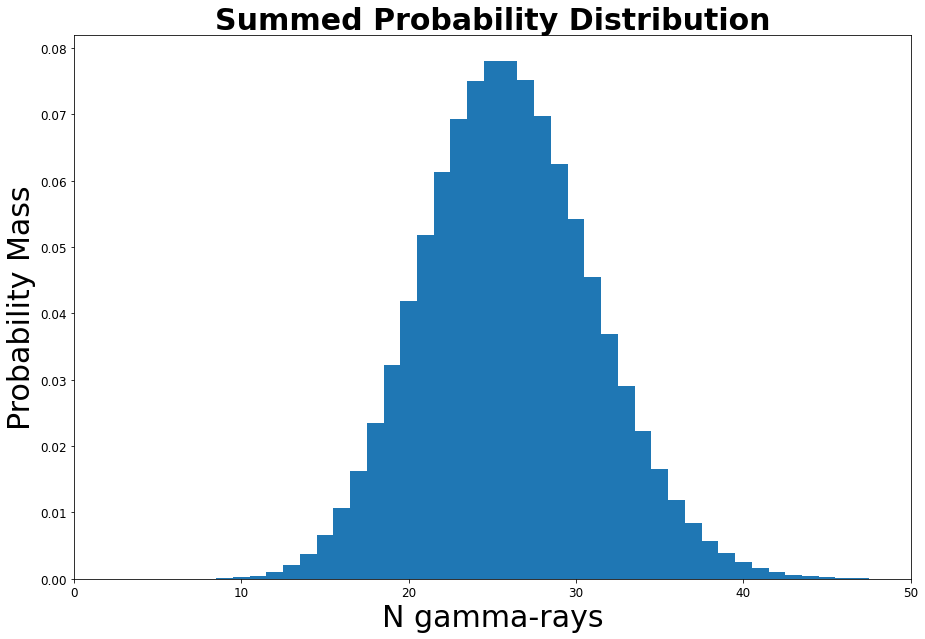

In [12]:
plot_sum(poisson, bins, 0, 50, fsize, lsize)

In [13]:
N = 1
mu = 5.2*5

xlim1, xlim2 = (0, 50)
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
poisson = stats.poisson.pmf(x, mu)

poisson = Nconvolve(poisson, N)

bins = np.arange(xlim1, len(poisson)+1)
bins = bins - (bins[1]-bins[0])/2

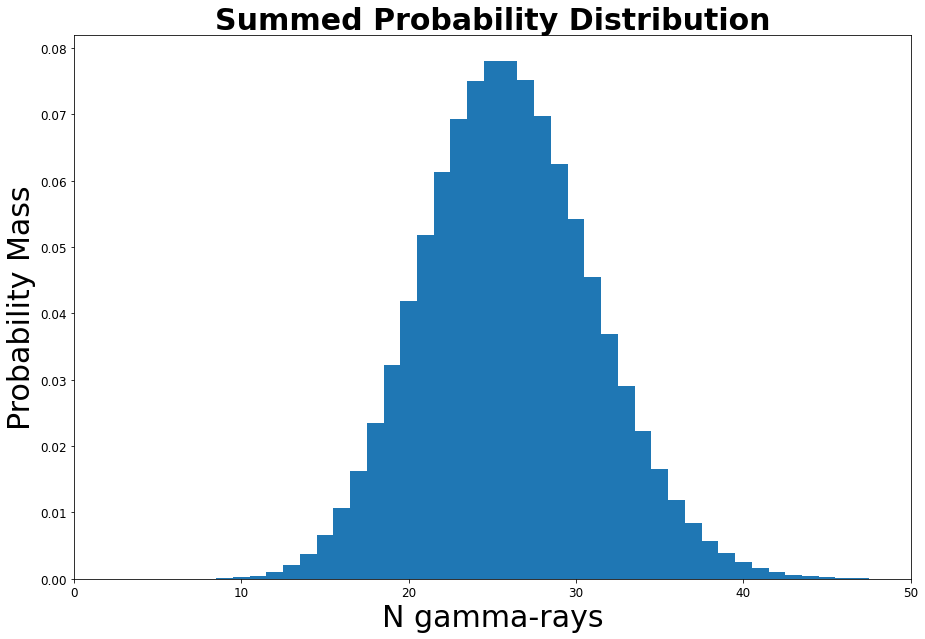

In [14]:
plot_sum(poisson, bins, 0, 50, fsize, lsize)

We can see that the distribution has retained its characteristic shape of a Poisson distribution. This makes sense conceptually because since the Poisson distribution describes the rate of occurring events then we should expect the distribution to retain its shape even though the time span of the observation expands. 

Even more specifically, we see that the Poisson distribution summed 5 times is equivalent to a Poisson distribution with $\mu = 5.2 * 5 $ and in general, summing a Poisson distribution with mean $\mu$, $N$ times yields a distribution equaivalent to a Poisson distribution with $\mu * N $. 

Mathematically speaking, we are adding several equal Poisson distribution in the form:
$$ \frac{\lambda^{x}}{x!} e^{-\lambda} $$
Which is essentially a linear combination of the above expression. Thus, it also makes sense mathematically that the distribution remains a Poisson distribution.

## C)

Now, we average over the number of days, and we will see that in order to do this, we need to scale the x-axis. As we do this, keep in mind that the mean of the distribution is also scaled (since the mean is not located at x=0). Therefore, we need to shift the distribution to 're-align' it at $\mu$.

In [15]:
def plot_average(distribution, bins, left, right, fsize, lsize):
    fig, ax = plt.subplots(2, 1)
    plt.tick_params(labelsize = lsize/2)
    ax[0].stairs(distribution, bins, fill=True)
    ax[0].set_xlim([left, right])
    ax[0].set_xlabel('Average Cosmic Rays', fontsize = fsize/2)
    ax[0].set_ylabel('Probability Mass', fontsize = fsize/2)
    ax[0].set_title('Averaged Probability Distribution', fontsize = fsize, fontweight = 'bold')
    ax[1].stairs(distribution, bins, fill=True)
    ax[1].set_xlabel('Average Cosmic Rays', fontsize = fsize/2)
    ax[1].set_ylabel('Probability Mass', fontsize = fsize/2)
    ax[1].set_xlim([left, right])
    ax[1].set_ylim([1e-13, 1e0])
    ax[1].set_yscale('log')
    plt.show()

In [16]:
mu = 5.2

In [17]:
N = 5

xlim1, xlim2 = (0, 50)
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
poisson = stats.poisson.pmf(x, mu)

poisson = Nconvolve(poisson, N)

bins = np.arange(xlim1, len(poisson)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N

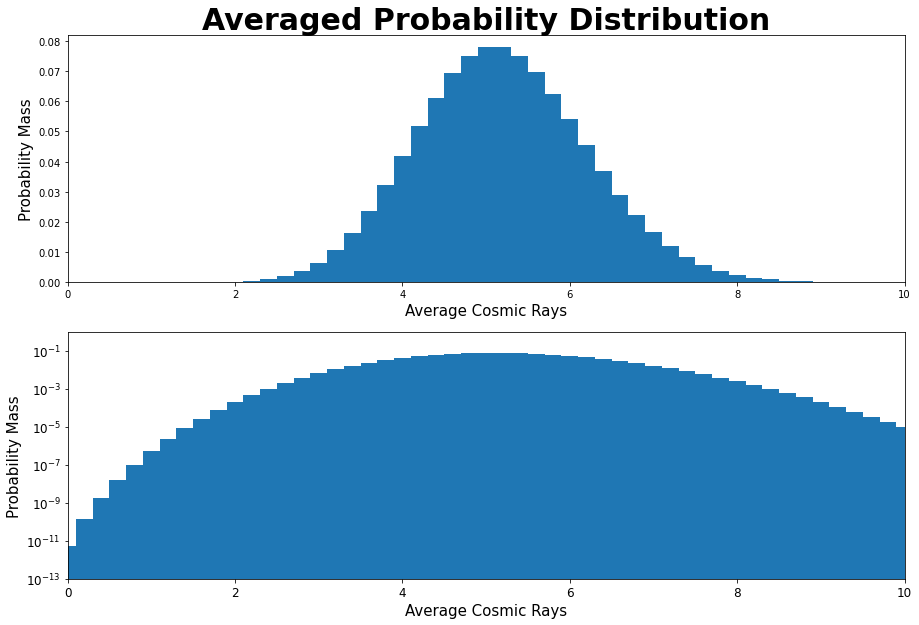

In [18]:
plot_average(poisson, bins, 0, 10, fsize, lsize)

In [19]:
N = 100

xlim1, xlim2 = (0, 50)
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
poisson = stats.poisson.pmf(x, mu)

poisson = Nconvolve(poisson, N)

bins = np.arange(xlim1, len(poisson)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N

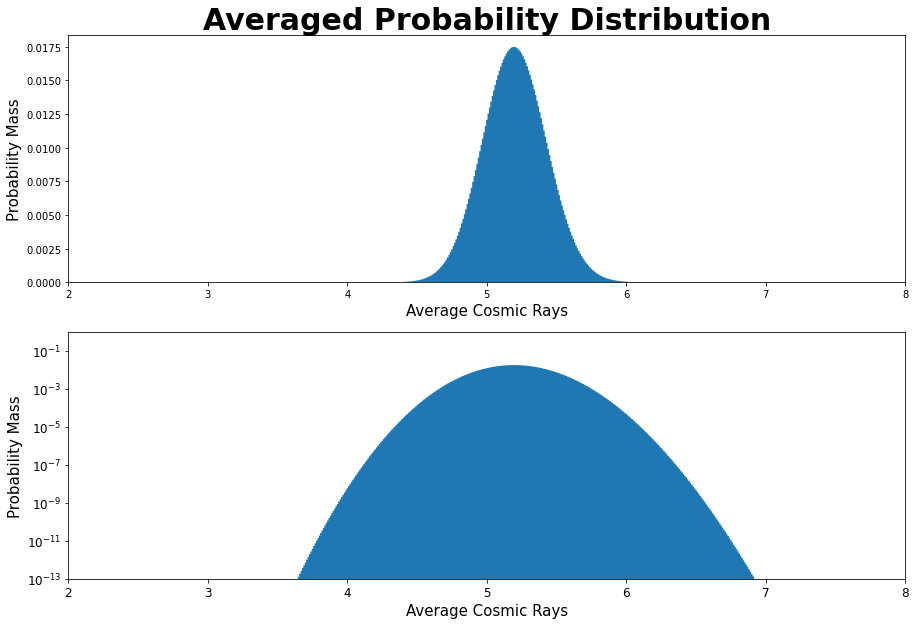

In [20]:
plot_average(poisson, bins, 2, 8, fsize, lsize)

We can see that when we average the distribution with itself over and over, it becomes more and more indistinguishable from a Gaussian. We can also see that the semilog plot (with the y-axis being plotted in log) gets a more and more parabolic shape. The Central Limit Theorem states that as you sum and average a distribution with itself many times over, it will eventually appear to look more and more like a Gaussian distribution and converge around its mean. Thus, our plots above are in accordance with what the Central Limit Theorem states.

We also see that as we average the distribution converges around its mean. 

## D)

Set $N = 20$ and $Y = 8$. Then, $Y*N = 160$
Now, we imagine that we observe for N days and that we Y*N gamma-rays coming from our observed gamma-ray source. Let's calculate the 'sigma' of our observation - namely, how large is the probability in 'sigma' that the incoming sigal was produced by the background noise, as we have described above.
In this case, we need to use the pmf() (equivalent to the pdf()) of the discrete distribution). We average the distribution 20 times and visualize this.

In [21]:
Y = 8
N = 20

xlim1, xlim2 = (0, 50)
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
poisson = stats.poisson.pmf(x, mu)

poisson = Nconvolve(poisson, N)

bins = np.arange(xlim1, len(poisson)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N

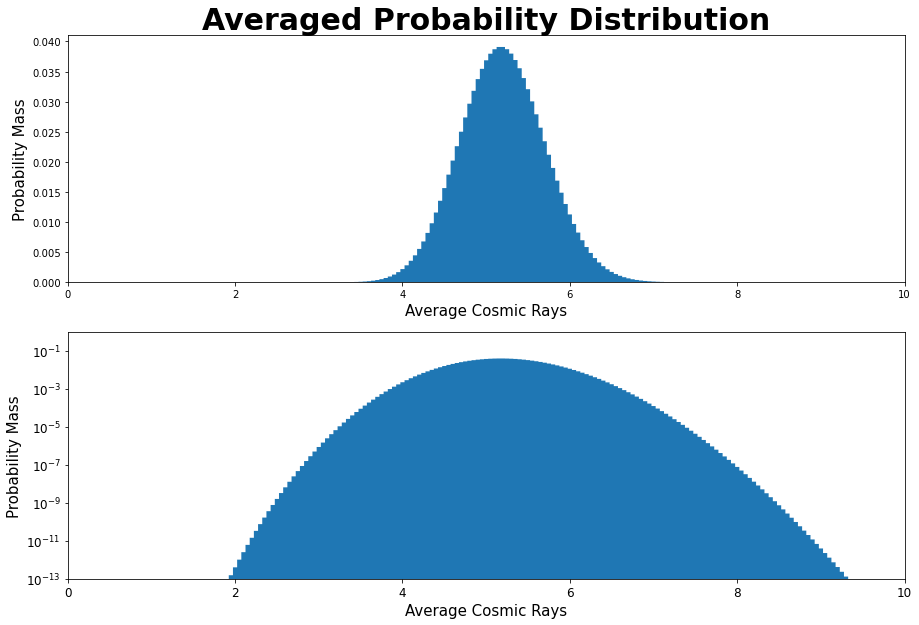

In [22]:
plot_average(poisson, bins, 0, 10, fsize, lsize)

Then we take the integral ($sf()$, or survival function, right of that function to our value Y) keeping in mind we have to subtract this from 1 since it's an integral from the right and to our value.

In [23]:
prob_poisson = stats.poisson(mu * N).sf(N * Y)
prob_poisson

1.360395486542889e-07

In [24]:
sigma = stats.poisson.ppf(1 - prob_poisson, mu)

In [25]:
print(f'The sigma of the observation is {sigma}.')

The sigma of the observation is 21.0.


## Problem 2

Let's pick a skewed continuous distribution - the Rayleigh distribution.

## A)

Now, we are going to show how this distribution changes as we average over more observing intervals N.

In [26]:
N = 1

xlim1, xlim2 = 0, 20
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
rayleigh = stats.rayleigh.pdf(x)
rayleigh

array([0.00000000e+00, 6.06530660e-01, 2.70670566e-01, 3.33269896e-02,
       1.34185051e-03, 1.86332659e-05, 9.13798785e-08, 1.60281439e-10,
       1.01313324e-13, 2.31908140e-17, 1.92874985e-21, 5.84220147e-26,
       6.45622339e-31, 2.60651142e-36, 3.84829901e-42, 2.07951494e-48,
       4.11553500e-55, 2.98466977e-62, 7.93535640e-70, 7.73748139e-78,
       2.76779305e-86])

In [27]:
new_rayleigh = rayleigh
if N != 1:
    for i in range(0, N-1): 
        new_rayleigh = signal.convolve(rayleigh, new_rayleigh)
rayleigh = new_rayleigh

To plot the average, we need to 'shrink' the x-axis by a factor of the number of Rayleigh distributions we have added which is in this case N.

In [28]:
bins = np.arange(xlim1, len(rayleigh)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N # This is where we shrink the x-axis by dividing by N
bins

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5])

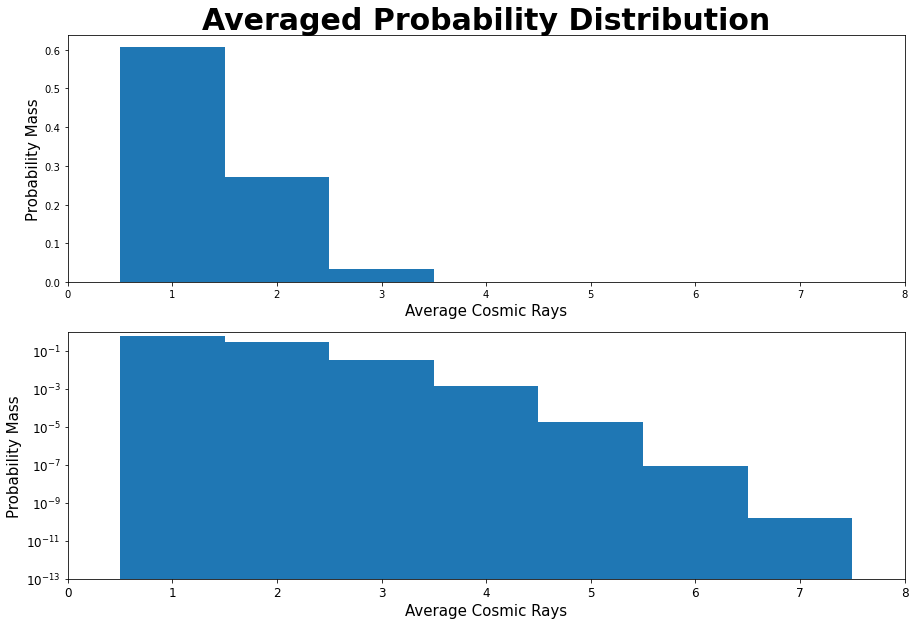

In [29]:
plot_average(rayleigh, bins, 0, 8, fsize, lsize)

In [30]:
N = 2

xlim1, xlim2 = 0, 20
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
rayleigh = stats.rayleigh.pdf(x)

new_rayleigh = rayleigh
if N != 1:
    for i in range(0, N-1): 
        new_rayleigh = signal.convolve(rayleigh, new_rayleigh)
rayleigh = new_rayleigh

bins = np.arange(xlim1, len(rayleigh)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N # This is where we shrink the x-axis by dividing by N

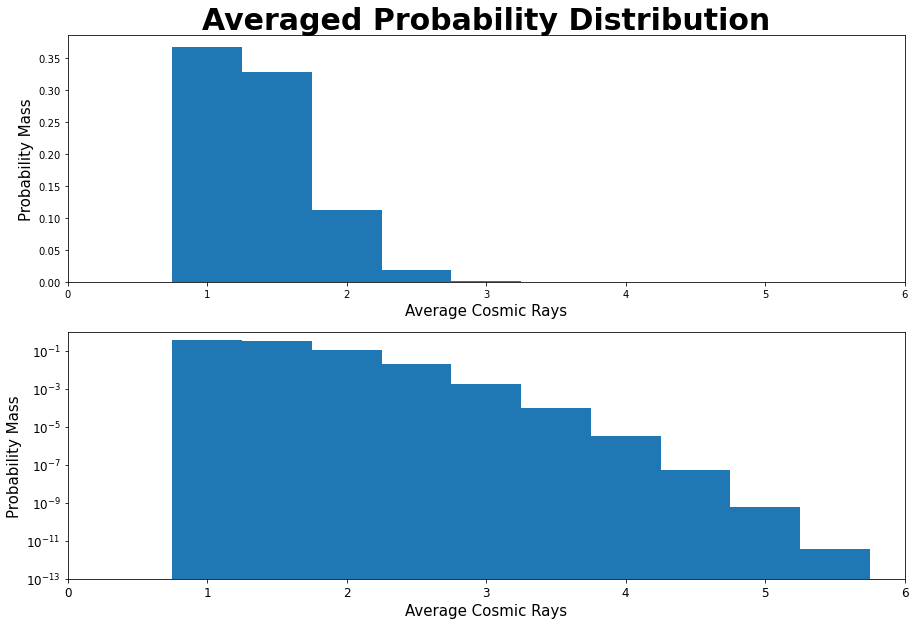

In [31]:
plot_average(rayleigh, bins, 0, 6, fsize, lsize)

In [32]:
N = 5

xlim1, xlim2 = 0, 20
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
rayleigh = stats.rayleigh.pdf(x)

new_rayleigh = rayleigh
if N != 1:
    for i in range(0, N-1): 
        new_rayleigh = signal.convolve(rayleigh, new_rayleigh)
rayleigh = new_rayleigh

bins = np.arange(xlim1, len(rayleigh)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N # This is where we shrink the x-axis by dividing by N

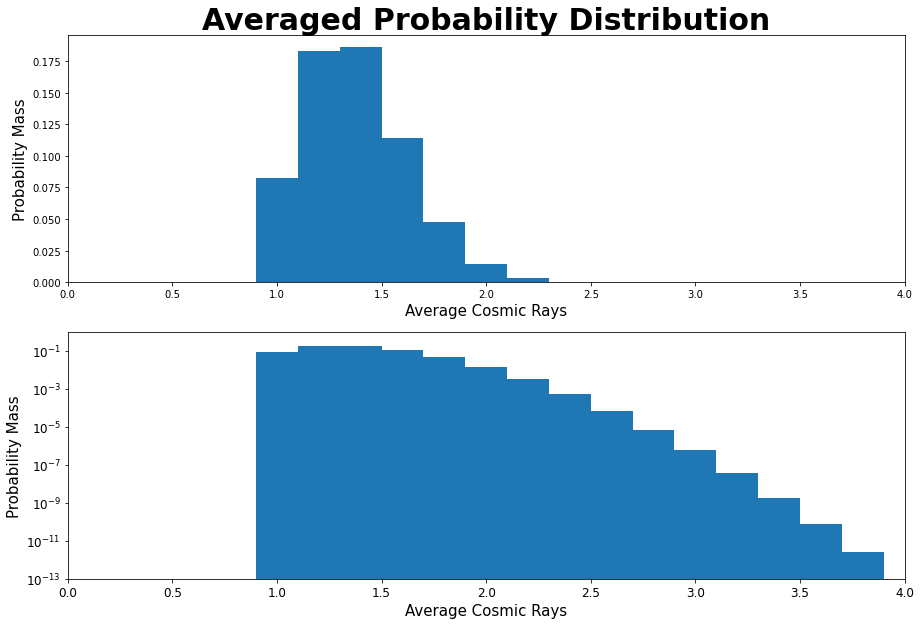

In [33]:
plot_average(rayleigh, bins, 0, 4, fsize, lsize)

In [34]:
N = 8

xlim1, xlim2 = 0, 20
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
rayleigh = stats.rayleigh.pdf(x)

new_rayleigh = rayleigh
if N != 1:
    for i in range(0, N-1): 
        new_rayleigh = signal.convolve(rayleigh, new_rayleigh)
rayleigh = new_rayleigh

bins = np.arange(xlim1, len(rayleigh)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N # This is where we shrink the x-axis by dividing by N

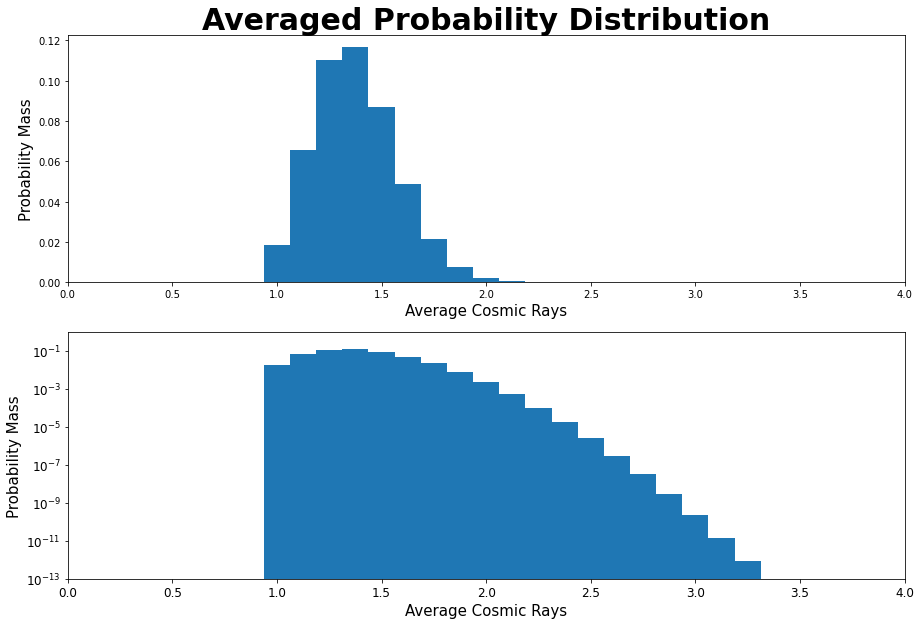

In [35]:
plot_average(rayleigh, bins, 0, 4, fsize, lsize)

In [36]:
N = 10

xlim1, xlim2 = 0, 20
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
rayleigh = stats.rayleigh.pdf(x)

new_rayleigh = rayleigh
if N != 1:
    for i in range(0, N-1): 
        new_rayleigh = signal.convolve(rayleigh, new_rayleigh)
rayleigh = new_rayleigh

bins = np.arange(xlim1, len(rayleigh)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N # This is where we shrink the x-axis by dividing by N

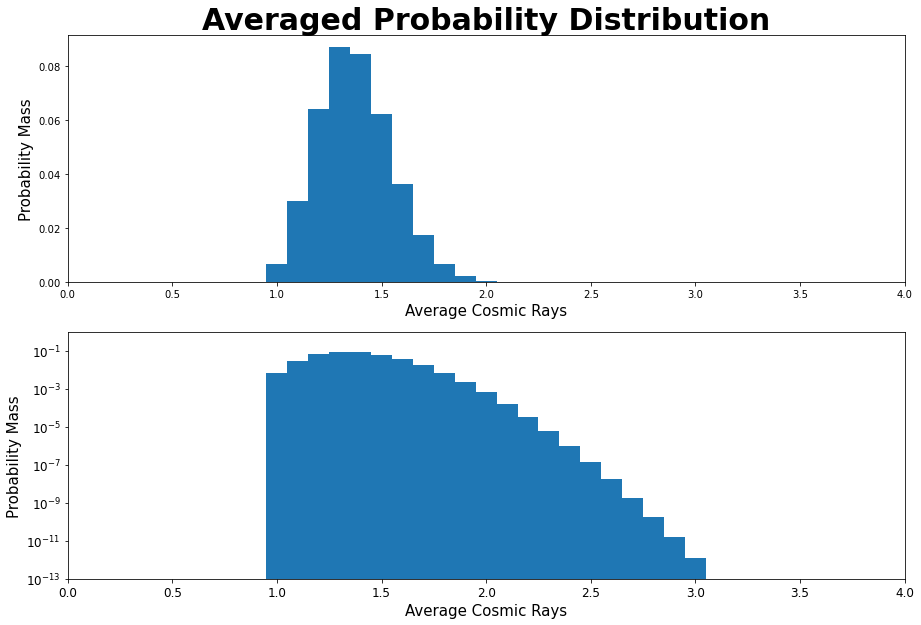

In [37]:
plot_average(rayleigh, bins, 0, 4, fsize, lsize)

In [38]:
N = 14

xlim1, xlim2 = 0, 20
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
rayleigh = stats.rayleigh.pdf(x)

new_rayleigh = rayleigh
if N != 1:
    for i in range(0, N-1): 
        new_rayleigh = signal.convolve(rayleigh, new_rayleigh)
rayleigh = new_rayleigh

bins = np.arange(xlim1, len(rayleigh)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N # This is where we shrink the x-axis by dividing by N

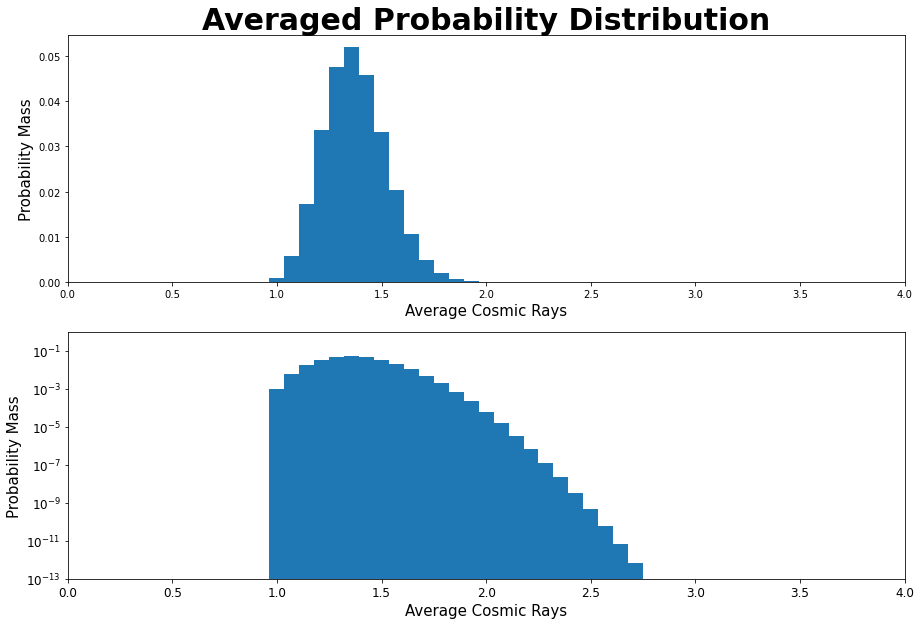

In [39]:
plot_average(rayleigh, bins, 0, 4, fsize, lsize)

In [40]:
N = 20

xlim1, xlim2 = 0, 20
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
rayleigh = stats.rayleigh.pdf(x)

new_rayleigh = rayleigh
if N != 1:
    for i in range(0, N-1):
        new_rayleigh = signal.convolve(rayleigh, new_rayleigh)
rayleigh = new_rayleigh

bins = np.arange(xlim1, len(rayleigh)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N # This is where we shrink the x-axis by dividing by N

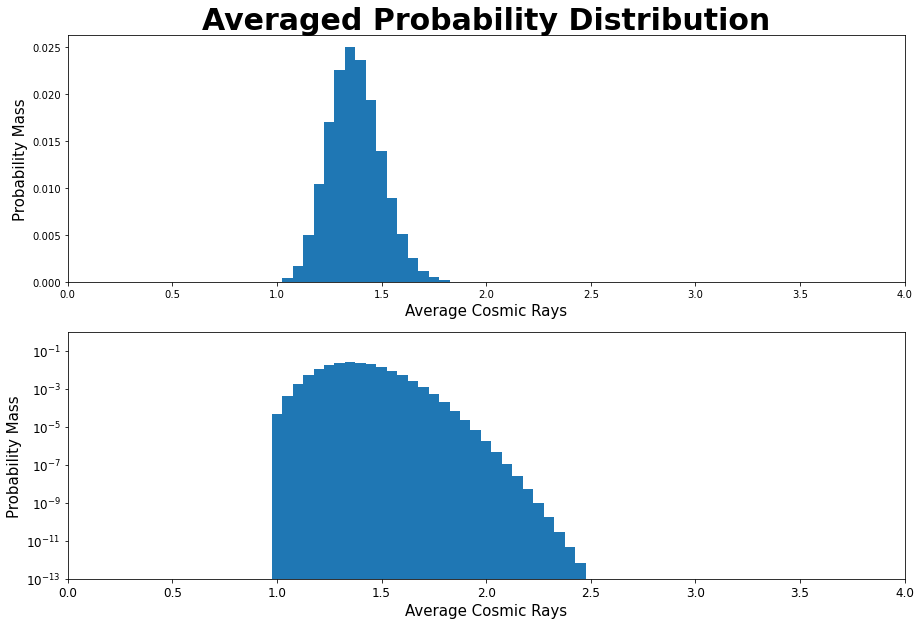

In [41]:
plot_average(rayleigh, bins, 0, 4, fsize, lsize)

In [42]:
N = 50

xlim1, xlim2 = 0, 20
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
rayleigh = stats.rayleigh.pdf(x)

new_rayleigh = rayleigh
if N != 1:
    for i in range(0, N-1): 
        new_rayleigh = signal.convolve(rayleigh, new_rayleigh)
rayleigh = new_rayleigh

bins = np.arange(xlim1, len(rayleigh)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N # This is where we shrink the x-axis by dividing by N

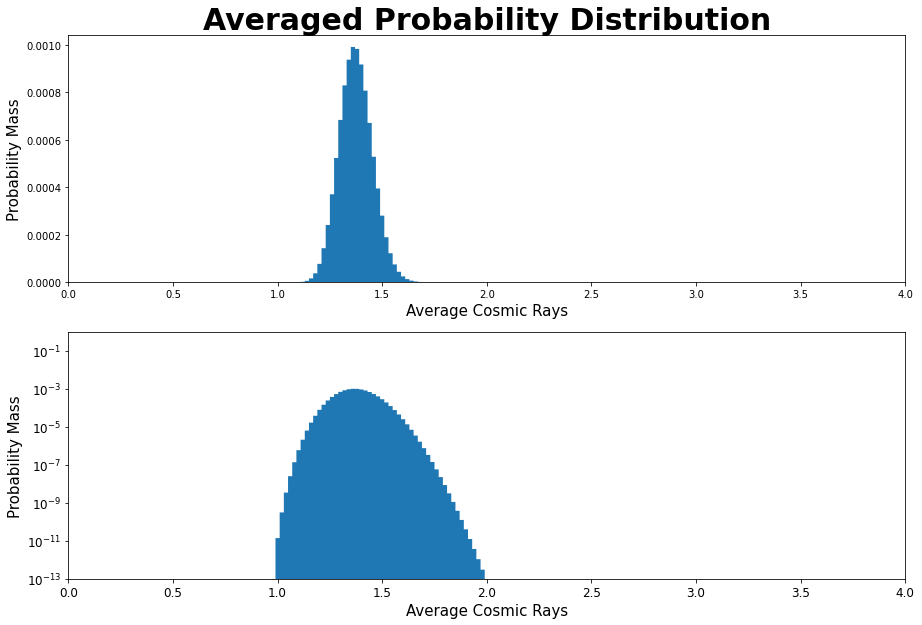

In [43]:
plot_average(rayleigh, bins, 0, 4, fsize, lsize)

In [44]:
N = 70

xlim1, xlim2 = 0, 20
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
rayleigh = stats.rayleigh.pdf(x)

new_rayleigh = rayleigh
if N != 1:
    for i in range(0, N-1): 
        new_rayleigh = signal.convolve(rayleigh, new_rayleigh)
rayleigh = new_rayleigh

bins = np.arange(xlim1, len(rayleigh)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N # This is where we shrink the x-axis by dividing by N

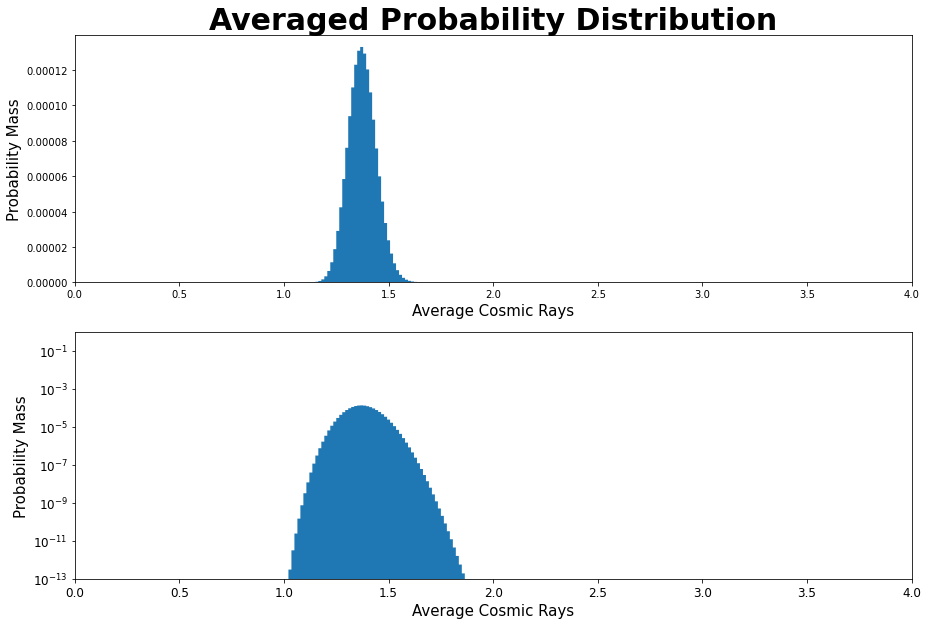

In [45]:
plot_average(rayleigh, bins, 0, 4, fsize, lsize)

In [46]:
N = 80

xlim1, xlim2 = 0, 20
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
rayleigh = stats.rayleigh.pdf(x)

new_rayleigh = rayleigh
if N != 1:
    for i in range(0, N-1): 
        new_rayleigh = signal.convolve(rayleigh, new_rayleigh)
rayleigh = new_rayleigh

bins = np.arange(xlim1, len(rayleigh)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N # This is where we shrink the x-axis by dividing by N

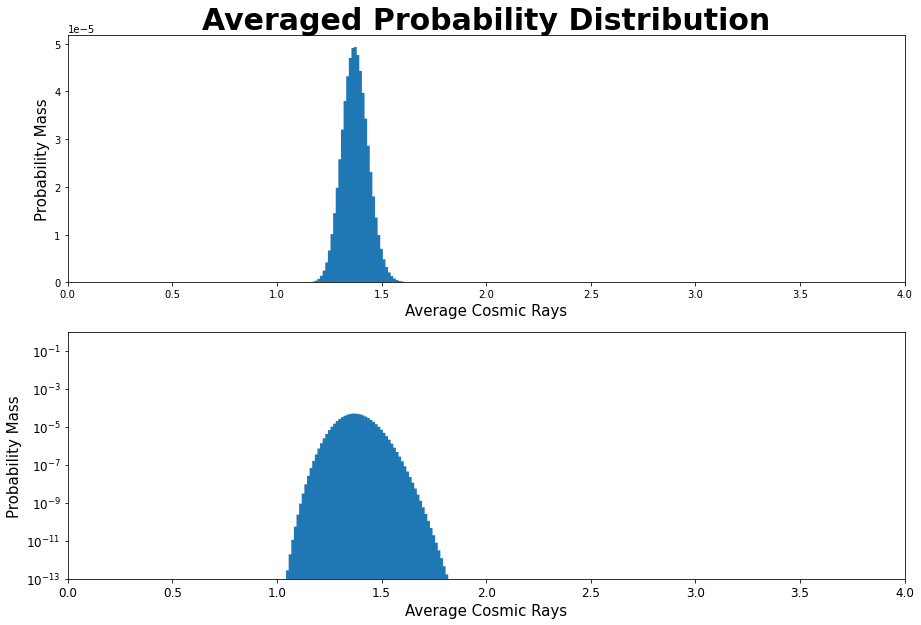

In [47]:
plot_average(rayleigh, bins, 0, 4, fsize, lsize)

As we can see, the distribution becomes more and more similar to a Gaussian as we average more and more Rayleigh distributions together.

The distribution remains centered on and converges around the mean value and its standard deviation decreases. In the case of a signal being represented by the distribution, the signal would thus become more defined as we keep averaging.

## B)

After a certain number of averages N, the distribution essentially becomes a Gaussian distribution. It seems like plotting the log of the y-axis was helpful here in determining after how many N the distribution becomes Gaussian, so if we consider both the general shape of the distribution and its semilog-plot, I would say the distribution becomes Gaussian after about 70 observation intervals ($N = 70$). This we can see since the semilog plot has a parabolic shape (which is a characteristic of the Gaussian) and that the non-semilog plot is hard to distinguish from a Gaussian plot.

## Problem 3

Now, we take a look at the analyses that come up in actual observations, such as from neutron star mergers detected by gravity-waves. For this problem, we assume that we have an observation from an optical telescope with a thermal noise background from its CCD. This background appears as a zero-mean Gaussian with constant width over the image.

## Version 1

Let's pretend we have an alert from LIGO (an interferometry observatory) that is also seen by the x-ray/UV satellite SWIFT. We get a precise location from SWIFT and take an image of that part of the sky. From SWIFT's accuracy, we know which pixel to look for a counterpart in.

## A)

We have a Gaussian background with width $X = 5$. We see a signal of strength $Y = 22$. Let's calculate the significance of this detection. Will we be able to claim a discovery? Let's see.

In [48]:
X = 5
Y = 22

prob_dist = 1 - stats.norm.cdf(Y, loc = 0, scale = X)
sigma = stats.norm.ppf(1-prob_dist)

In [49]:
print(f'The probability of the background producing this signal is {prob_dist:.2e}, and the sigma corresponding to this probability is {sigma:.1f}.')

The probability of the background producing this signal is 5.41e-06, and the sigma corresponding to this probability is 4.4.


Thus, unfortunately, if our threshold for discovery is $5\sigma$ then this is not enough to claim a discovery and we have to continue sampling data.

## Version 2

This, time we have an alert from LIGO, but no associated detection from SWIFT. This could be because it is a black hole-merger, a black hole-neutron star merger (neither seem to emit X-rays or UV light), or it could because SWIFT was indisposed at the time (wrong side of the earth in its orbit). Whatever the cause, we know what region of the sky to look in, but not which pixel.

## B)

If we have to look for a signal in 10k pixels, the probability distribution of our background would be the original distribution times the number of pixels.

In this case, since we are looking for a signal in each of the 10k pixels, we have to ask the question:
What is the probability distribution of of our background from Part 1 summed with itself 10k times?

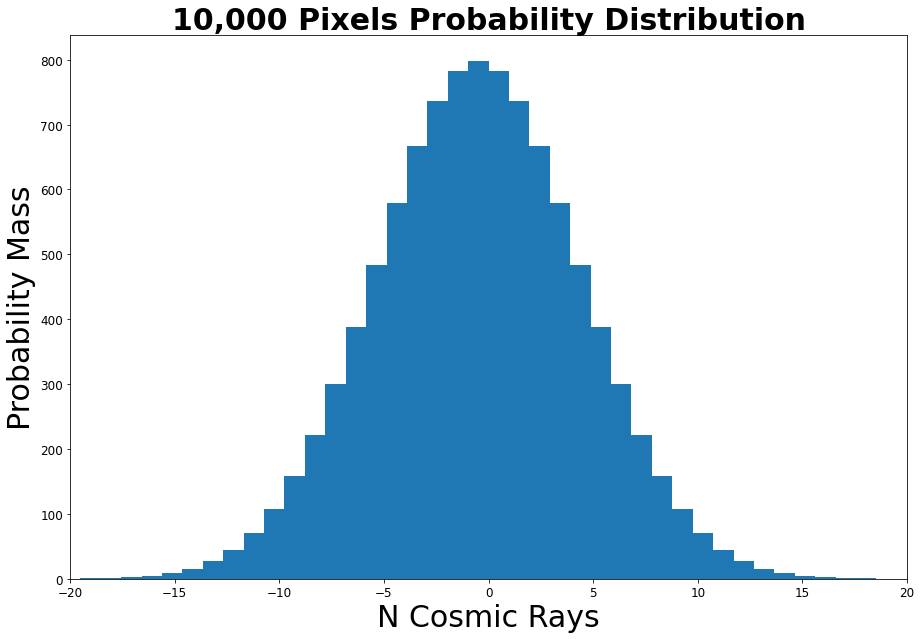

In [50]:
N_pixels = 10000

xlim1, xlim2 = -20, 20
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
dist = stats.norm.pdf(x, loc = 0, scale = X)

dist = dist * N_pixels

bins = np.linspace(-20, 20, len(dist)+1)
bins = bins - (bins[1]-bins[0])/2

left, right = (-20, 20)
fig, ax = plt.subplots(1, 1)
plt.tick_params(labelsize = lsize/2)
ax.stairs(dist, bins, fill=True)
ax.set_xlim([left, right])
ax.set_xlabel('N Cosmic Rays', fontsize = fsize)
ax.set_ylabel('Probability Mass', fontsize = fsize)
ax.set_title('10,000 Pixels Probability Distribution', fontsize = fsize, fontweight = 'bold')
plt.show()

xlim1, xlim2 = (0, 50)
x = np.linspace(xlim1, xlim2, xlim2-xlim1+1)
poisson = stats.poisson.pmf(x, mu)

poisson = Nconvolve(poisson, N)

bins = np.arange(xlim1, len(poisson)+1)
bins = bins - (bins[1]-bins[0])/2
bins = bins/N

## C)

Now, we take our brightest candidate signal from the region - assuming it has the same signal as in Version 1 - and calculate the significance of this detection. Remember, we use the same Y as in Part A.

In [51]:
prob_dist = stats.norm.sf(Y, loc = 0, scale = X) * N_pixels
sigma = stats.norm.ppf(1-prob_dist / N_pixels)

In [52]:
print(f'The probability of the background producing this signal is {prob_dist:.3e}, and the sigma corresponding to this probability is {sigma:.1f}.')

The probability of the background producing this signal is 5.413e-02, and the sigma corresponding to this probability is 4.4.


## Problem 4

The statistical issue we were exploring in the previous problem is called a trials factor (sometimes known as a look-elsewhere effect). This is an important effect, as if you search through a million locations, you would expect to se ~1 one in a million event. However, it is also often over estimated how big an impact this makes on the sensitivity of a search. So in this part of the lab we are going to invert the problem.**

Let us again assume we have a Gaussian background (same parameters as Problem 3).

## A)

Let's calculate the signal required for a 5-sigma detection in Version 1.

In [53]:
prob_5sigma = 1/3.5e6
y = stats.norm.ppf(1 - prob_5sigma, loc = 0, scale = X)
# y_prob = (1 - stats.norm.cdf(val, loc = 0, scale = X))
y

25.003157174651903

In [54]:
print(f'The signal would need to be of at least strength {y:.1f} to be a 5-sigma detection.')

The signal would need to be of at least strength 25.0 to be a 5-sigma detection.


## B)

In [55]:
prob_5sigma = 1/3.5e6
y2 = stats.norm.ppf(1 - prob_5sigma / N_pixels, loc = 0, scale = X)
# y_prob = (1 - stats.norm.cdf(val, loc = 0, scale = X))
y2

32.755131970257935

In [56]:
print(f'The signal would need to be of at least strength {y2:.1f} to be a 5-sigma detection.')

The signal would need to be of at least strength 32.8 to be a 5-sigma detection.


## C)

In [57]:
frac = y2/y
frac

1.3100398378275584

In [58]:
print(f'From above, we see that the signal has to be {(frac-1)*100:.1f} % stronger with 10k pixels.')

From above, we see that the signal has to be 31.0 % stronger with 10k pixels.


This is not really that big of a difference given that we have 10,000 times more pixels in the latter scenario. Really, this comes from the fact that the probability of sigma is already really small. Therefore, $\frac{prob_{5sigma}}{N_{pixels}}$ is not going to change a lot as our pixel count increases. This is why the sensitivity penalty of many trials is so low.

## D)

Going off our discussion above, we can use the fraction $\frac{prob_{5sigma}}{N_{pixels}}$ to find the sensitivity penalty as we change the pixel count. This penalty is thus proportional to $\frac{prob_{5sigma}}{N_{pixels}}$. If we take an example of a pixel count of 1e8, the sensitivity penalty will not be very big, and our new detection threshold changes only by a small factor in signal strength:

In [59]:
N_pixels = 1e8

prob_5sigma = 1/3.5e6
y3 = stats.norm.ppf(1 - prob_5sigma / N_pixels, loc = 0, scale = X)
y3

39.04403748459095

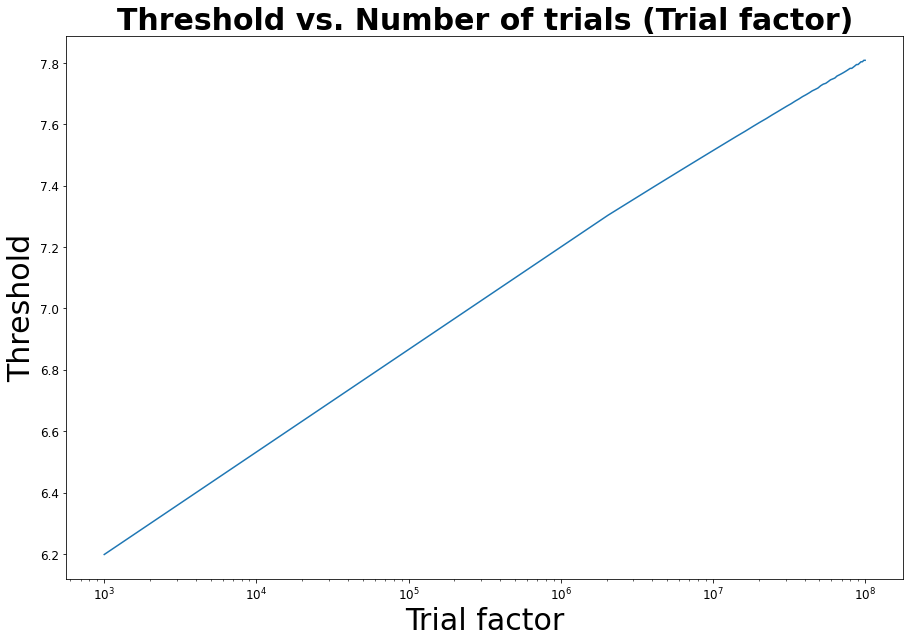

In [60]:
N_trials = np.linspace(1e3, 1e8)
probs_5sigma = prob_5sigma / N_trials
thresholds = stats.norm.ppf(1 - probs_5sigma)

fig, ax = plt.subplots(1, 1)
plt.tick_params(labelsize = lsize/2)
ax.plot(N_trials, thresholds)
ax.set_xlabel('Trial factor', fontsize = fsize)
ax.set_ylabel('Threshold', fontsize = fsize)
ax.set_title('Threshold vs. Number of trials (Trial factor)', fontsize = fsize, fontweight = 'bold')
ax.set_xscale('log')
plt.show()

We see that the relation between the threshold and the probability of five sigma is approximately proportional to the log of the trial factor.